# 01 - Business Understanding


Using Data Mining the aim is to idenity and predict the factors 
which affect the use of bike-sharing rental services 

# 02 -Data Exploration 

In [61]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('basics').getOrCreate()

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [62]:
df = spark.read.csv('train.csv')

df_pd = pd.read_csv('train.csv')

In [63]:
df.show()

df.columns 

+-------------------+------+-------+----------+-------+-----+------+--------+---------+------+----------+-----+
|                _c0|   _c1|    _c2|       _c3|    _c4|  _c5|   _c6|     _c7|      _c8|   _c9|      _c10| _c11|
+-------------------+------+-------+----------+-------+-----+------+--------+---------+------+----------+-----+
|           datetime|season|holiday|workingday|weather| temp| atemp|humidity|windspeed|casual|registered|count|
|2011-01-01 00:00:00|     1|      0|         0|      1| 9.84|14.395|      81|        0|     3|        13|   16|
|2011-01-01 01:00:00|     1|      0|         0|      1| 9.02|13.635|      80|        0|     8|        32|   40|
|2011-01-01 02:00:00|     1|      0|         0|      1| 9.02|13.635|      80|        0|     5|        27|   32|
|2011-01-01 03:00:00|     1|      0|         0|      1| 9.84|14.395|      75|        0|     3|        10|   13|
|2011-01-01 04:00:00|     1|      0|         0|      1| 9.84|14.395|      75|        0|     0|         1

['_c0',
 '_c1',
 '_c2',
 '_c3',
 '_c4',
 '_c5',
 '_c6',
 '_c7',
 '_c8',
 '_c9',
 '_c10',
 '_c11']

In [64]:
df_pd.corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.096758,0.164011,0.163439
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.043799,-0.020956,-0.005393
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.319111,0.119460,0.011594
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.135918,-0.109340,-0.128655
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369
casual,0.096758,0.043799,-0.319111,-0.135918,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414
registered,0.164011,-0.020956,0.119460,-0.109340,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948


In [65]:
# rename columns 
df = df.withColumnRenamed('_c0', 'datetime')
df = df.withColumnRenamed('_c1', 'season')
df = df.withColumnRenamed('_c2', 'holiday')
df = df.withColumnRenamed('_c3', 'workday')
df = df.withColumnRenamed('_c4', 'weather')
df = df.withColumnRenamed('_c5', 'temp')
df = df.withColumnRenamed('_c6', 'feels_temp')
df = df.withColumnRenamed('_c7', 'humidity')
df = df.withColumnRenamed('_c8', 'windspeed')
df = df.withColumnRenamed('_c9', 'casual')
df = df.withColumnRenamed('_c10', 'registered')
df = df.withColumnRenamed('_c11', 'count')

df.show()



+-------------------+------+-------+----------+-------+-----+----------+--------+---------+------+----------+-----+
|           datetime|season|holiday|   workday|weather| temp|feels_temp|humidity|windspeed|casual|registered|count|
+-------------------+------+-------+----------+-------+-----+----------+--------+---------+------+----------+-----+
|           datetime|season|holiday|workingday|weather| temp|     atemp|humidity|windspeed|casual|registered|count|
|2011-01-01 00:00:00|     1|      0|         0|      1| 9.84|    14.395|      81|        0|     3|        13|   16|
|2011-01-01 01:00:00|     1|      0|         0|      1| 9.02|    13.635|      80|        0|     8|        32|   40|
|2011-01-01 02:00:00|     1|      0|         0|      1| 9.02|    13.635|      80|        0|     5|        27|   32|
|2011-01-01 03:00:00|     1|      0|         0|      1| 9.84|    14.395|      75|        0|     3|        10|   13|
|2011-01-01 04:00:00|     1|      0|         0|      1| 9.84|    14.395|

In [66]:
#Filter out initial row as it is column lable 
df = df.filter(df.datetime!='datetime')

df.show()

df.columns

+-------------------+------+-------+-------+-------+-----+----------+--------+---------+------+----------+-----+
|           datetime|season|holiday|workday|weather| temp|feels_temp|humidity|windspeed|casual|registered|count|
+-------------------+------+-------+-------+-------+-----+----------+--------+---------+------+----------+-----+
|2011-01-01 00:00:00|     1|      0|      0|      1| 9.84|    14.395|      81|        0|     3|        13|   16|
|2011-01-01 01:00:00|     1|      0|      0|      1| 9.02|    13.635|      80|        0|     8|        32|   40|
|2011-01-01 02:00:00|     1|      0|      0|      1| 9.02|    13.635|      80|        0|     5|        27|   32|
|2011-01-01 03:00:00|     1|      0|      0|      1| 9.84|    14.395|      75|        0|     3|        10|   13|
|2011-01-01 04:00:00|     1|      0|      0|      1| 9.84|    14.395|      75|        0|     0|         1|    1|
|2011-01-01 05:00:00|     1|      0|      0|      2| 9.84|     12.88|      75|   6.0032|     0| 

['datetime',
 'season',
 'holiday',
 'workday',
 'weather',
 'temp',
 'feels_temp',
 'humidity',
 'windspeed',
 'casual',
 'registered',
 'count']

In [67]:
#Dataframe Components Summary 

df.select("datetime", "season", 'holiday', 'workday').summary().show()
df.select('weather',"temp", "feels_temp", 'humidity', 'windspeed').summary().show()
df.select("casual", "registered", 'count',).summary().show()

+-------+-------------------+------------------+-------------------+------------------+
|summary|           datetime|            season|            holiday|           workday|
+-------+-------------------+------------------+-------------------+------------------+
|  count|              10886|             10886|              10886|             10886|
|   mean|               null|2.5066139996325556|0.02856880396839978|0.6808745177291935|
| stddev|               null|1.1161743093443237|0.16659885062470944|0.4661591687997361|
|    min|2011-01-01 00:00:00|                 1|                  0|                 0|
|    25%|               null|               2.0|                0.0|               0.0|
|    50%|               null|               3.0|                0.0|               1.0|
|    75%|               null|               4.0|                0.0|               1.0|
|    max|2012-12-19 23:00:00|                 4|                  1|                 1|
+-------+-------------------+---

In [8]:
df.printSchema()

df_pd.info()


root
 |-- datetime: string (nullable = true)
 |-- season: string (nullable = true)
 |-- holiday: string (nullable = true)
 |-- workday: string (nullable = true)
 |-- weather: string (nullable = true)
 |-- temp: string (nullable = true)
 |-- feels_temp: string (nullable = true)
 |-- humidity: string (nullable = true)
 |-- windspeed: string (nullable = true)
 |-- casual: string (nullable = true)
 |-- registered: string (nullable = true)
 |-- count: string (nullable = true)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8  

+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|             10886|
|   mean|191.57413191254824|
| stddev|181.14445383028493|
|    min|                 1|
|    25%|              42.0|
|    50%|             145.0|
|    75%|             284.0|
|    max|                99|
+-------+------------------+



<AxesSubplot:ylabel='Frequency'>

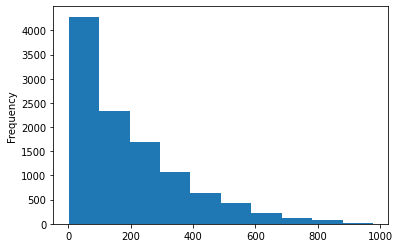

In [9]:
df.select('count').summary().show()
df_pd['count'].plot.hist()

<AxesSubplot:ylabel='season'>

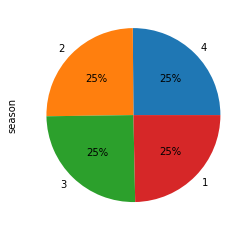

In [10]:
df_pd['season'].value_counts().plot.pie(autopct='%1.0f%%')

<AxesSubplot:ylabel='weather'>

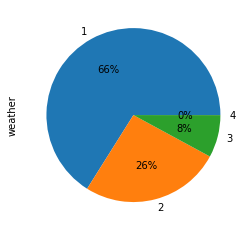

In [11]:
df_pd['weather'].value_counts().plot.pie(autopct='%1.0f%%')

<AxesSubplot:ylabel='workingday'>

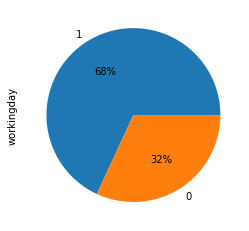

In [12]:
df_pd['workingday'].value_counts().plot.pie(autopct='%1.0f%%')

In [13]:
#Check if there are any null or missing values
from pyspark.sql.functions import col

null_counts = df.select([col(column).isNull().alias(column) for column in df.columns]).toPandas().sum()
print("Null value counts in DataFrame:")
print(null_counts)

Null value counts in DataFrame:
datetime      0
season        0
holiday       0
workday       0
weather       0
temp          0
feels_temp    0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64


In [74]:
df.select("season", "holiday", 'workday').summary().show()
df.select('weather',"temp", "feels_temp", 'humidity', 'windspeed').summary().show()
df.select("casual", "registered", 'count',).summary().show()

+-------+------------------+-------------------+------------------+
|summary|            season|            holiday|           workday|
+-------+------------------+-------------------+------------------+
|  count|             10886|              10886|             10886|
|   mean|2.5066139996325556|0.02856880396839978|0.6808745177291935|
| stddev|1.1161743093443237|0.16659885062470944|0.4661591687997361|
|    min|                 1|                  0|                 0|
|    25%|               2.0|                0.0|               0.0|
|    50%|               3.0|                0.0|               1.0|
|    75%|               4.0|                0.0|               1.0|
|    max|                 4|                  1|                 1|
+-------+------------------+-------------------+------------------+

+-------+------------------+------------------+-----------------+------------------+------------------+
|summary|           weather|              temp|       feels_temp|          humi

In [15]:
#Data Validaiton


#dealing with outliers in humidity and windspeed variables 

from pyspark.sql.functions import col, mean, stddev

# Calculate mean and std deviation for the 'humidity' column
stats = df.select(mean(col("humidity")).alias('mean_humidity'), 
                  stddev(col("humidity")).alias('stddev_humidity')).collect()

# Extract mean and std deviation values
mean_val = stats[0]['mean_humidity']
stddev_val = stats[0]['stddev_humidity']

# Define threshold for outliers (e.g., 3 standard deviations)
threshold = 3

# Filter out outliers based on the Z-score
df = df.filter((col("humidity") > mean_val - threshold * stddev_val) & 
                            (col("humidity") < mean_val + threshold * stddev_val))


stats = df.select(mean(col("windspeed")).alias('mean_windspeed'), 
                    stddev(col("windspeed")).alias('stddev_windspeed')).collect()

# Extract mean and std deviation values
mean_val = stats[0]['mean_windspeed']
stddev_val = stats[0]['stddev_windspeed']

# Define threshold for outliers
threshold = 3.0  # Example threshold as a float

# Filter out outliers based on the Z-score using the threshold
df = df.filter((col("windspeed") > mean_val - threshold * stddev_val) & 
                            (col("windspeed") < mean_val + threshold * stddev_val))


# Show the filtered data
df.show()


+-------------------+------+-------+-------+-------+-----+----------+--------+---------+------+----------+-----+
|           datetime|season|holiday|workday|weather| temp|feels_temp|humidity|windspeed|casual|registered|count|
+-------------------+------+-------+-------+-------+-----+----------+--------+---------+------+----------+-----+
|2011-01-01 00:00:00|     1|      0|      0|      1| 9.84|    14.395|      81|        0|     3|        13|   16|
|2011-01-01 01:00:00|     1|      0|      0|      1| 9.02|    13.635|      80|        0|     8|        32|   40|
|2011-01-01 02:00:00|     1|      0|      0|      1| 9.02|    13.635|      80|        0|     5|        27|   32|
|2011-01-01 03:00:00|     1|      0|      0|      1| 9.84|    14.395|      75|        0|     3|        10|   13|
|2011-01-01 04:00:00|     1|      0|      0|      1| 9.84|    14.395|      75|        0|     0|         1|    1|
|2011-01-01 05:00:00|     1|      0|      0|      2| 9.84|     12.88|      75|   6.0032|     0| 

In [16]:
df.select("season", "holiday", 'workday').summary().show()
df.select('weather',"temp", "feels_temp", 'humidity', 'windspeed').summary().show()
df.select("casual", "registered", 'count',).summary().show()

+-------+-----------------+--------------------+------------------+
|summary|           season|             holiday|           workday|
+-------+-----------------+--------------------+------------------+
|  count|            10798|               10798|             10798|
|   mean|2.514632339322097|0.028709020188923875|0.6805889979625857|
| stddev| 1.11433892311282| 0.16699519452123884|0.4662700375216369|
|    min|                1|                   0|                 0|
|    25%|              2.0|                 0.0|               0.0|
|    50%|              3.0|                 0.0|               1.0|
|    75%|              4.0|                 0.0|               1.0|
|    max|                4|                   1|                 1|
+-------+-----------------+--------------------+------------------+

+-------+------------------+------------------+-----------------+------------------+------------------+
|summary|           weather|              temp|       feels_temp|          humi

# 03 - Data Preparation

In [17]:
# Import in the relevant types.
from pyspark.sql.types import (StructField,StringType,IntegerType,StructType)
df.show() 

+-------------------+------+-------+-------+-------+-----+----------+--------+---------+------+----------+-----+
|           datetime|season|holiday|workday|weather| temp|feels_temp|humidity|windspeed|casual|registered|count|
+-------------------+------+-------+-------+-------+-----+----------+--------+---------+------+----------+-----+
|2011-01-01 00:00:00|     1|      0|      0|      1| 9.84|    14.395|      81|        0|     3|        13|   16|
|2011-01-01 01:00:00|     1|      0|      0|      1| 9.02|    13.635|      80|        0|     8|        32|   40|
|2011-01-01 02:00:00|     1|      0|      0|      1| 9.02|    13.635|      80|        0|     5|        27|   32|
|2011-01-01 03:00:00|     1|      0|      0|      1| 9.84|    14.395|      75|        0|     3|        10|   13|
|2011-01-01 04:00:00|     1|      0|      0|      1| 9.84|    14.395|      75|        0|     0|         1|    1|
|2011-01-01 05:00:00|     1|      0|      0|      2| 9.84|     12.88|      75|   6.0032|     0| 

In [18]:
#Split datetime varaible into Year, Month, Day and Hour
from pyspark.sql.functions import split

split_col = split(df['datetime'], '-')

df = df.withColumn('Year', split_col.getItem(0))
df = df.withColumn('Month', split_col.getItem(1))
df = df.withColumn('Day_Time', split_col.getItem(2))


split_col = split(df['Day_Time'], '\s+')
df = df.withColumn('Day', split_col.getItem(0))
df = df.withColumn('Time', split_col.getItem(1))

split_col = split(df['Time'], ':')
df = df.withColumn('Hour', split_col.getItem(0))

df = df.drop('datetime')
df = df.drop('Day_Time')
df = df.drop('Time')
df.show() 


+------+-------+-------+-------+-----+----------+--------+---------+------+----------+-----+----+-----+---+----+
|season|holiday|workday|weather| temp|feels_temp|humidity|windspeed|casual|registered|count|Year|Month|Day|Hour|
+------+-------+-------+-------+-----+----------+--------+---------+------+----------+-----+----+-----+---+----+
|     1|      0|      0|      1| 9.84|    14.395|      81|        0|     3|        13|   16|2011|   01| 01|  00|
|     1|      0|      0|      1| 9.02|    13.635|      80|        0|     8|        32|   40|2011|   01| 01|  01|
|     1|      0|      0|      1| 9.02|    13.635|      80|        0|     5|        27|   32|2011|   01| 01|  02|
|     1|      0|      0|      1| 9.84|    14.395|      75|        0|     3|        10|   13|2011|   01| 01|  03|
|     1|      0|      0|      1| 9.84|    14.395|      75|        0|     0|         1|    1|2011|   01| 01|  04|
|     1|      0|      0|      2| 9.84|     12.88|      75|   6.0032|     0|         1|    1|2011

In [19]:
#Reformt Schema
from pyspark.sql.types import StringType, IntegerType, FloatType, BooleanType

df = df.withColumn("season" ,df["season"].cast(IntegerType()))
df = df.withColumn("holiday" ,df["holiday"].cast(BooleanType()))
df = df.withColumn("workday" ,df["workday"].cast(BooleanType()))
df = df.withColumn("weather" ,df["weather"].cast(IntegerType()))
df = df.withColumn("temp" ,df["temp"].cast(FloatType()))
df = df.withColumn("feels_temp" ,df["feels_temp"].cast(FloatType()))
df = df.withColumn("humidity" ,df["humidity"].cast(IntegerType()))
df = df.withColumn("windspeed" ,df["windspeed"].cast(FloatType()))
df = df.withColumn("casual" ,df["casual"].cast(IntegerType()))
df = df.withColumn("registered" ,df["registered"].cast(IntegerType()))
df = df.withColumn("count" ,df["count"].cast(IntegerType()))
df = df.withColumn("Year" ,df["Year"].cast(IntegerType()))
df = df.withColumn("Month" ,df["Month"].cast(IntegerType()))
df = df.withColumn("Day" ,df["Day"].cast(IntegerType()))
df = df.withColumn("Hour" ,df["Hour"].cast(IntegerType()))


df.printSchema()

root
 |-- season: integer (nullable = true)
 |-- holiday: boolean (nullable = true)
 |-- workday: boolean (nullable = true)
 |-- weather: integer (nullable = true)
 |-- temp: float (nullable = true)
 |-- feels_temp: float (nullable = true)
 |-- humidity: integer (nullable = true)
 |-- windspeed: float (nullable = true)
 |-- casual: integer (nullable = true)
 |-- registered: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Hour: integer (nullable = true)



In [20]:
df.show()

+------+-------+-------+-------+-----+----------+--------+---------+------+----------+-----+----+-----+---+----+
|season|holiday|workday|weather| temp|feels_temp|humidity|windspeed|casual|registered|count|Year|Month|Day|Hour|
+------+-------+-------+-------+-----+----------+--------+---------+------+----------+-----+----+-----+---+----+
|     1|  false|  false|      1| 9.84|    14.395|      81|      0.0|     3|        13|   16|2011|    1|  1|   0|
|     1|  false|  false|      1| 9.02|    13.635|      80|      0.0|     8|        32|   40|2011|    1|  1|   1|
|     1|  false|  false|      1| 9.02|    13.635|      80|      0.0|     5|        27|   32|2011|    1|  1|   2|
|     1|  false|  false|      1| 9.84|    14.395|      75|      0.0|     3|        10|   13|2011|    1|  1|   3|
|     1|  false|  false|      1| 9.84|    14.395|      75|      0.0|     0|         1|    1|2011|    1|  1|   4|
|     1|  false|  false|      2| 9.84|     12.88|      75|   6.0032|     0|         1|    1|2011

In [21]:
# Reformat Season and Weather Variables 
from pyspark.sql.functions import when

df_reformated = df.select("*") 

df_reformated = df_reformated.withColumn("season",
                   when(df_reformated["season"] == "1", "Spring")
                   .when(df_reformated["season"] == "2", "Summer")
                   .when(df_reformated["season"] == "3", "Autumn")
                   .when(df_reformated["season"] == "4", "Winter")
                   .otherwise(df_reformated["season"]))

df_reformated = df_reformated.withColumn("weather",
                   when(df_reformated["weather"] == "1", "Sunny")
                   .when(df_reformated["weather"] == "2", "Cloudy")
                   .when(df_reformated["weather"] == "3", "Lite R/S")
                   .when(df_reformated["weather"] == "4", "Severe Con")
                   .otherwise(df_reformated["weather"]))

df.show()
df_reformated.show()


+------+-------+-------+-------+-----+----------+--------+---------+------+----------+-----+----+-----+---+----+
|season|holiday|workday|weather| temp|feels_temp|humidity|windspeed|casual|registered|count|Year|Month|Day|Hour|
+------+-------+-------+-------+-----+----------+--------+---------+------+----------+-----+----+-----+---+----+
|     1|  false|  false|      1| 9.84|    14.395|      81|      0.0|     3|        13|   16|2011|    1|  1|   0|
|     1|  false|  false|      1| 9.02|    13.635|      80|      0.0|     8|        32|   40|2011|    1|  1|   1|
|     1|  false|  false|      1| 9.02|    13.635|      80|      0.0|     5|        27|   32|2011|    1|  1|   2|
|     1|  false|  false|      1| 9.84|    14.395|      75|      0.0|     3|        10|   13|2011|    1|  1|   3|
|     1|  false|  false|      1| 9.84|    14.395|      75|      0.0|     0|         1|    1|2011|    1|  1|   4|
|     1|  false|  false|      2| 9.84|     12.88|      75|   6.0032|     0|         1|    1|2011

In [22]:
df.select("season", "holiday", 'workday').summary().show()
df.select('weather',"temp", "feels_temp", 'humidity', 'windspeed').summary().show()
df.select("casual", "registered", 'count',).summary().show()
df.select("Year", "Month", 'Day','Hour').summary().show()

+-------+-----------------+
|summary|           season|
+-------+-----------------+
|  count|            10798|
|   mean|2.514632339322097|
| stddev| 1.11433892311282|
|    min|                1|
|    25%|                2|
|    50%|                3|
|    75%|                4|
|    max|                4|
+-------+-----------------+

+-------+------------------+------------------+------------------+------------------+------------------+
|summary|           weather|              temp|        feels_temp|          humidity|         windspeed|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|             10798|             10798|             10798|             10798|             10798|
|   mean|1.4134098907205037|20.250992711434034|23.680536565669797| 62.08890535284312|12.610226537413366|
| stddev|0.6287645353850797| 7.794579515067669| 8.467297181406838|19.002796991353833| 7.852936815713861|
|    min|                 1|     

# 04 - Data Transformation


Correlation Matrix:
season        0.160784
holiday      -0.005470
workday       0.011051
weather      -0.126759
temp          0.392972
feels_temp    0.388312
humidity     -0.329620
windspeed     0.110041
casual        0.690474
registered    0.970880
count         1.000000
Year          0.258659
Month         0.164817
Day           0.020808
Hour          0.402149
Name: count, dtype: float64


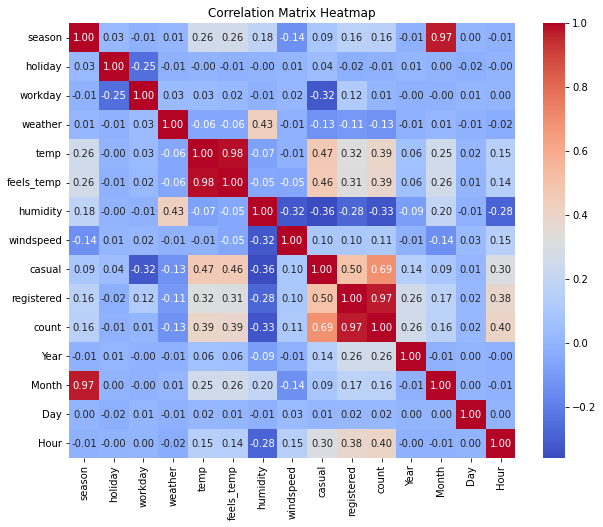

In [23]:
#Data Reduction
#Convert dataframe to Pandas to view correlation matirx
df_pd = df.toPandas()

correlation_matrix = df_pd.corr()

# Print correlation matrix
print("Correlation Matrix:")
print(correlation_matrix['count'])

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()


In [24]:
#Drop Varaibles that are seen as to not have a high correlations with target variable "count"
df.show()

df = df.drop('holiday', 'workday', 'weather', 'humidity', 'Day')
df_reformated = df_reformated.drop('holiday', 'workday', 'weather', 'humidity', 'Day')

df.show()
df_reformated.show()


+------+-------+-------+-------+-----+----------+--------+---------+------+----------+-----+----+-----+---+----+
|season|holiday|workday|weather| temp|feels_temp|humidity|windspeed|casual|registered|count|Year|Month|Day|Hour|
+------+-------+-------+-------+-----+----------+--------+---------+------+----------+-----+----+-----+---+----+
|     1|  false|  false|      1| 9.84|    14.395|      81|      0.0|     3|        13|   16|2011|    1|  1|   0|
|     1|  false|  false|      1| 9.02|    13.635|      80|      0.0|     8|        32|   40|2011|    1|  1|   1|
|     1|  false|  false|      1| 9.02|    13.635|      80|      0.0|     5|        27|   32|2011|    1|  1|   2|
|     1|  false|  false|      1| 9.84|    14.395|      75|      0.0|     3|        10|   13|2011|    1|  1|   3|
|     1|  false|  false|      1| 9.84|    14.395|      75|      0.0|     0|         1|    1|2011|    1|  1|   4|
|     1|  false|  false|      2| 9.84|     12.88|      75|   6.0032|     0|         1|    1|2011

# 05 - Data Mining Methods

### Classification Methods 
- Logistic regression

### Clustering Methods 
- K Means Clustering

### Regression Methods
- Linear Regression

#### Tree Methods
- Single Decision Tree
- Random Forest 
- Gradient Boosted ree Classifer 

# 06 - Data Mining Method Analysis


In [25]:
# K-Means Clustering 



# 07 - Data Mining


### K-MEANS CLUSTERING
#### PySpark

In [26]:
from pyspark.ml.clustering import KMeans
df.head(1)

df.printSchema()

root
 |-- season: integer (nullable = true)
 |-- temp: float (nullable = true)
 |-- feels_temp: float (nullable = true)
 |-- windspeed: float (nullable = true)
 |-- casual: integer (nullable = true)
 |-- registered: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Hour: integer (nullable = true)



In [27]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import IntegerType

df = df.withColumn("count", df["count"].cast(IntegerType()))

df.printSchema()

root
 |-- season: integer (nullable = true)
 |-- temp: float (nullable = true)
 |-- feels_temp: float (nullable = true)
 |-- windspeed: float (nullable = true)
 |-- casual: integer (nullable = true)
 |-- registered: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Hour: integer (nullable = true)



In [28]:
feat_cols = ['season', 'temp', 'feels_temp', 'windspeed', 'casual', 'registered', 'count', 'Year', 'Month', 'Hour']

vec_assembler = VectorAssembler(inputCols = feat_cols, outputCol='features')

final_data = vec_assembler.transform(df)

from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
final_data

DataFrame[season: int, temp: float, feels_temp: float, windspeed: float, casual: int, registered: int, count: int, Year: int, Month: int, Hour: int, features: vector]

In [29]:
scalerModel = scaler.fit(final_data)
cluster_final_data = scalerModel.transform(final_data)

### Train and Evaluate Model

In [30]:
kmeans3 = KMeans(featuresCol='scaledFeatures',k=3)
kmeans2 = KMeans(featuresCol='scaledFeatures',k=2)

In [31]:
model3 = kmeans3.fit(cluster_final_data)
model2 = kmeans2.fit(cluster_final_data)

In [32]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Make predictions
predictions3 = model3.transform(cluster_final_data)
predictions2 = model2.transform(cluster_final_data)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette3 = evaluator.evaluate(predictions3)
print("With k=3 Silhouette with squared euclidean distance = " + str(silhouette3))

silhouette2 = evaluator.evaluate(predictions2)
print("With k=2 Silhouette with squared euclidean distance = " + str(silhouette2))

With k=3 Silhouette with squared euclidean distance = 0.03669993317836136
With k=2 Silhouette with squared euclidean distance = 0.5268436067323328


In [33]:
#RESULTS 
centers3 = model3.clusterCenters()
print("Cluster Centers for k=3:")
for center in centers3:
    print(center)

centers2 = model2.clusterCenters()
print("Cluster Centers for k=2:")
for center in centers2:
    print(center)

Cluster Centers for k=3:
[3.04984386e+00 2.58042336e+00 2.78577910e+00 1.31330018e+00
 2.84203442e-01 5.99732443e-01 5.78428195e-01 4.02277404e+03
 2.71915282e+00 1.25694625e+00]
[1.11927895e+00 1.69220161e+00 1.89083071e+00 1.80436164e+00
 2.38505685e-01 5.52561565e-01 5.26487792e-01 4.02279287e+03
 7.33958859e-01 1.60046345e+00]
[2.41018539e+00 3.46959414e+00 3.66043219e+00 1.75664157e+00
 1.68004092e+00 1.97901666e+00 2.11363683e+00 4.02314527e+03
 2.05397871e+00 2.19644087e+00]
Cluster Centers for k=2:
[2.56917815e+00 3.30118381e+00 3.49592378e+00 1.70097590e+00
 1.43993712e+00 1.81753183e+00 1.91272553e+00 4.02307461e+03
 2.21039468e+00 2.18316195e+00]
[2.03002922e+00 2.08839731e+00 2.28982809e+00 1.53680081e+00
 2.00858483e-01 4.61391721e-01 4.40090732e-01 4.02277304e+03
 1.67685017e+00 1.28942952e+00]


In [34]:
# Evaluate clustering by computing Within Set Sum of Squared Errors.
for k in range(2,9):
    kmeans = KMeans(featuresCol='scaledFeatures',k=k)
    model = kmeans.fit(cluster_final_data)
    predictions = model.transform(cluster_final_data)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    print("With K={}".format(k))
    print("Silhouette with squared euclidean distance = " + str(silhouette))
    print('--'*30)

With K=2
Silhouette with squared euclidean distance = 0.5268436067323328
------------------------------------------------------------
With K=3
Silhouette with squared euclidean distance = 0.03669993317836136
------------------------------------------------------------
With K=4
Silhouette with squared euclidean distance = 0.03615135622816182
------------------------------------------------------------
With K=5
Silhouette with squared euclidean distance = -0.0035520824009105797
------------------------------------------------------------
With K=6
Silhouette with squared euclidean distance = -0.10744346825440726
------------------------------------------------------------
With K=7
Silhouette with squared euclidean distance = -0.12266337020618238
------------------------------------------------------------
With K=8
Silhouette with squared euclidean distance = -0.1583017381117915
------------------------------------------------------------


In [35]:
model3.transform(cluster_final_data).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1| 3268|
|         2| 3489|
|         0| 4041|
+----------+-----+



In [36]:
model2.transform(cluster_final_data).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1| 6260|
|         0| 4538|
+----------+-----+



### Linear Regression
#### PySpark

In [37]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

# Initialize Spark session
spark = SparkSession.builder.appName('lr_example').getOrCreate()

data = df

# Show the data
data.show()

# Print the schema of the DataFrame
data.printSchema()

+------+-----+----------+---------+------+----------+-----+----+-----+----+
|season| temp|feels_temp|windspeed|casual|registered|count|Year|Month|Hour|
+------+-----+----------+---------+------+----------+-----+----+-----+----+
|     1| 9.84|    14.395|      0.0|     3|        13|   16|2011|    1|   0|
|     1| 9.02|    13.635|      0.0|     8|        32|   40|2011|    1|   1|
|     1| 9.02|    13.635|      0.0|     5|        27|   32|2011|    1|   2|
|     1| 9.84|    14.395|      0.0|     3|        10|   13|2011|    1|   3|
|     1| 9.84|    14.395|      0.0|     0|         1|    1|2011|    1|   4|
|     1| 9.84|     12.88|   6.0032|     0|         1|    1|2011|    1|   5|
|     1| 9.02|    13.635|      0.0|     2|         0|    2|2011|    1|   6|
|     1|  8.2|     12.88|      0.0|     1|         2|    3|2011|    1|   7|
|     1| 9.84|    14.395|      0.0|     1|         7|    8|2011|    1|   8|
|     1|13.12|    17.425|      0.0|     8|         6|   14|2011|    1|   9|
|     1|15.5

In [38]:
data.columns

['season',
 'temp',
 'feels_temp',
 'windspeed',
 'casual',
 'registered',
 'count',
 'Year',
 'Month',
 'Hour']

In [39]:
# Define input columns and assembler
input_cols = ["season", "temp", "feels_temp", "windspeed", "casual", "registered", "Year", "Month", "Hour"]
assembler = VectorAssembler(inputCols=input_cols, outputCol="features")


output = assembler.transform(data)
output.select("features").show(3)

output.head(1)

+--------------------+
|            features|
+--------------------+
|[1.0,9.8400001525...|
|[1.0,9.0200004577...|
|[1.0,9.0200004577...|
+--------------------+
only showing top 3 rows



[Row(season=1, temp=9.84000015258789, feels_temp=14.395000457763672, windspeed=0.0, casual=3, registered=13, count=16, Year=2011, Month=1, Hour=0, features=DenseVector([1.0, 9.84, 14.395, 0.0, 3.0, 13.0, 2011.0, 1.0, 0.0]))]

In [40]:
final_data = output.select("features", "count")

In [41]:
# Print schema and show final data
final_data.printSchema()
final_data.show()

root
 |-- features: vector (nullable = true)
 |-- count: integer (nullable = true)

+--------------------+-----+
|            features|count|
+--------------------+-----+
|[1.0,9.8400001525...|   16|
|[1.0,9.0200004577...|   40|
|[1.0,9.0200004577...|   32|
|[1.0,9.8400001525...|   13|
|[1.0,9.8400001525...|    1|
|[1.0,9.8400001525...|    1|
|[1.0,9.0200004577...|    2|
|[1.0,8.1999998092...|    3|
|[1.0,9.8400001525...|    8|
|[1.0,13.119999885...|   14|
|[1.0,15.579999923...|   36|
|[1.0,14.760000228...|   56|
|[1.0,17.219999313...|   84|
|[1.0,18.860000610...|   94|
|[1.0,18.860000610...|  106|
|[1.0,18.040000915...|  110|
|[1.0,17.219999313...|   93|
|[1.0,18.040000915...|   67|
|[1.0,17.219999313...|   35|
|[1.0,17.219999313...|   37|
+--------------------+-----+
only showing top 20 rows



### Train Model

In [42]:
#Split data to training and test: 

train, test = final_data.randomSplit([0.7,0.3])

train.describe().show()
test.describe().show()

+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|              7578|
|   mean|191.44206914753232|
| stddev| 180.9382206945535|
|    min|                 1|
|    max|               977|
+-------+------------------+

+-------+-----------------+
|summary|            count|
+-------+-----------------+
|  count|             3220|
|   mean|193.4503105590062|
| stddev|182.3171427923791|
|    min|                1|
|    max|              948|
+-------+-----------------+



In [43]:
lr = LinearRegression(labelCol='count')

lrModel = lr.fit(train)

24/05/24 15:13:05 WARN Instrumentation: [8b873769] regParam is zero, which might cause numerical instability and overfitting.
24/05/24 15:13:05 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/24 15:13:05 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
24/05/24 15:13:05 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [44]:
# Print the coefficients and intercept for linear regression
print("Coefficients: {}".format(str(lrModel.coefficients)))
print("Intercept: {}".format(str(lrModel.intercept)))

Coefficients: [-3.9909745562142976e-13,-2.2727962120769484e-13,5.092535822326024e-13,3.7361569104955415e-13,0.9999999999999217,0.9999999999998503,1.4490633932431943e-10,1.215310805764472e-12,1.2869548723698198e-12]
Intercept: -2.914877697857804e-07


In [45]:
# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
trainingSummary.residuals.show()

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+--------------------+
|           residuals|
+--------------------+
|-7.43252126511606...|
|-7.56121831813061...|
|-6.85815848555648...|
|-5.67581537325168...|
|-3.28554961015470...|
|-7.33098026728384...|
|-5.43138867215020...|
|7.079559161127236...|
|-7.05568936609779...|
|6.894396165080252...|
|7.985079264472006...|
|7.45004058444465E-11|
|-7.22728543678385...|
|-7.97584220890712...|
|6.861000656499527...|
|6.759470760897557...|
|-7.85611575793154...|
|6.867040269753488...|
|-7.68878294366004...|
|7.757705589028774...|
+--------------------+
only showing top 20 rows



In [46]:
# Evaluate the model on the test data
test_results = lrModel.evaluate(test)
test_results.residuals.show()

+--------------------+
|           residuals|
+--------------------+
|-7.52780060508939...|
|-7.47686357271959...|
|-7.55058238155470...|
|6.888167813912105...|
|6.569855770521826...|
|6.862244106287108...|
|7.342748631344875...|
|6.302336430508149...|
|-7.47490958019625...|
|-7.02016222930979...|
|-7.52251594349218...|
|7.550227110186825...|
|-6.85815848555648...|
|9.595169103704393...|
|7.399503232363713...|
|4.570921419144724...|
|6.90213441956189E-11|
|-7.37783167892303...|
|-7.72288899497652...|
|-7.65147945003263...|
+--------------------+
only showing top 20 rows



In [47]:
# Print RMSE and R2 values
print("RMSE: {}".format(test_results.rootMeanSquaredError))
print("R2: {}".format(test_results.r2))

RMSE: 6.930763194084341e-11
R2: 1.0


In [48]:
# Describe the final data
final_data.describe().show()

+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|             10798|
|   mean|192.04093350620485|
| stddev| 181.3443943918951|
|    min|                 1|
|    max|               977|
+-------+------------------+



In [49]:
#Cross-Validation
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

# Define the linear regression model
lr = LinearRegression(labelCol='count')

# Create a parameter grid for cross-validation (if needed)
paramGrid = ParamGridBuilder().build()

# Define the cross-validator
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol='count'),
                          numFolds=5)  # Use 5-fold cross-validation

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(final_data)

# Get the best model from cross-validation
bestModel = cvModel.bestModel

# Evaluate the best model on the test data
test_results_cv = bestModel.evaluate(test)
print("Cross-Validated RMSE: {}".format(test_results_cv.rootMeanSquaredError))
print("Cross-Validated R2: {}".format(test_results_cv.r2))



24/05/24 15:13:07 WARN Instrumentation: [5bdec590] regParam is zero, which might cause numerical instability and overfitting.
24/05/24 15:13:08 WARN Instrumentation: [af00497f] regParam is zero, which might cause numerical instability and overfitting.
24/05/24 15:13:09 WARN Instrumentation: [34627db7] regParam is zero, which might cause numerical instability and overfitting.
24/05/24 15:13:09 WARN Instrumentation: [e55b0bb4] regParam is zero, which might cause numerical instability and overfitting.
24/05/24 15:13:10 WARN Instrumentation: [79ee0131] regParam is zero, which might cause numerical instability and overfitting.
24/05/24 15:13:11 WARN Instrumentation: [0874711b] regParam is zero, which might cause numerical instability and overfitting.


Cross-Validated RMSE: 1.6561166243631486e-11
Cross-Validated R2: 1.0


# 08 - Interpretation


#### K-means Clustering

In [50]:
viz_cols = feat_cols + ['prediction']

pdf3 = predictions3.select(viz_cols).toPandas()
pdf2 = predictions2.select(viz_cols).toPandas()

centers3_df = pd.DataFrame(model3.clusterCenters(), columns=feat_cols)
centers2_df = pd.DataFrame(model2.clusterCenters(), columns=feat_cols)

def plot_clusters(data, centers, k, feature):
    plt.figure(figsize=(20, 10))
    sns.scatterplot(x=feature, y='count', hue='predictIion', data=data, palette='viridis')
    #plt.scatter(centers[feature], centers['count'], s=300, c='red', marker='X')
    plt.title(f'K-means Clustering (k={k}) - {feature} vs Count')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Count')
    plt.show()
    

# Plot pair plot for k=3
plt.figure(figsize=(15, 15))
sns.pairplot(pdf3, hue='prediction', palette='viridis')
plt.suptitle('Pair Plot of Features (k=3)', y=1.02)
plt.show()

# Plot pair plot for k=2
plt.figure(figsize=(15, 15))
sns.pairplot(pdf2, hue='prediction', palette='viridis')
plt.suptitle('Pair Plot of Features (k=2)', y=1.02)
plt.show()

In [51]:
def plot_distribution(data, k):
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='season', y='count', hue='prediction', data=data, palette='viridis')
    plt.title(f'Distribution of Count across Seasons (k={k})')
    plt.xlabel('Season')
    plt.ylabel('Count')
    plt.legend(title='Cluster')
    plt.show()
    
    plt.figure(figsize=(12, 6))
    sns.violinplot(x='season', y='count', hue='prediction', data=data, palette='viridis')
    plt.title(f'Distribution of Count across Seasons (k={k})')
    plt.xlabel('Season')
    plt.ylabel('Count')
    plt.legend(title='Cluster')
    plt.show()
    
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Year', y='count', hue='prediction', data=data, palette='viridis')
    plt.title(f'Distribution of Count across Seasons (k={k})')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.legend(title='Cluster')
    plt.show()
    
    plt.figure(figsize=(12, 6))
    sns.violinplot(x='Year', y='count', hue='prediction', data=data, palette='viridis')
    plt.title(f'Distribution of Count across Seasons (k={k})')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.legend(title='Cluster')
    plt.show()
    
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Month', y='count', hue='prediction', data=data, palette='viridis')
    plt.title(f'Distribution of Count across Seasons (k={k})')
    plt.xlabel('Month')
    plt.ylabel('Count')
    plt.legend(title='Cluster')
    plt.show()
    
    plt.figure(figsize=(12, 6))
    sns.violinplot(x='Month', y='count', hue='prediction', data=data, palette='viridis')
    plt.title(f'Distribution of Count across Seasons (k={k})')
    plt.xlabel('Month')
    plt.ylabel('Count')
    plt.legend(title='Cluster')
    plt.show()
    
    plt.figure(figsize=(20, 12))
    sns.boxplot(x='Hour', y='count', hue='prediction', data=data, palette='viridis')
    plt.title(f'Distribution of Count across Seasons (k={k})')
    plt.xlabel('Hour')
    plt.ylabel('Count')
    plt.legend(title='Cluster')
    plt.show()
    
    plt.figure(figsize=(20, 12))
    sns.violinplot(x='Hour', y='count', hue='prediction', data=data, palette='viridis')
    plt.title(f'Distribution of Count across Seasons (k={k})')
    plt.xlabel('Hour')
    plt.ylabel('Count')
    plt.legend(title='Cluster')
    plt.show()

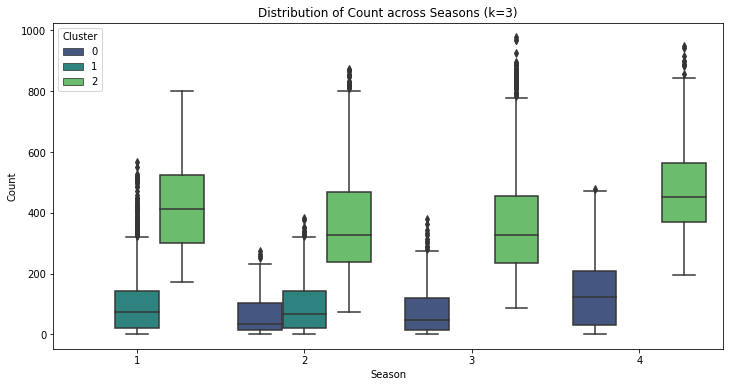

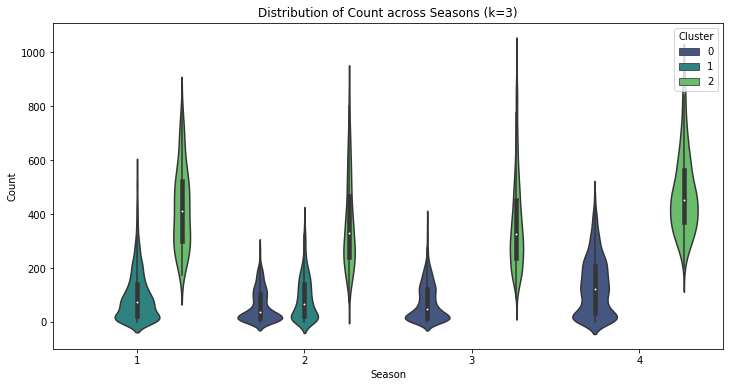

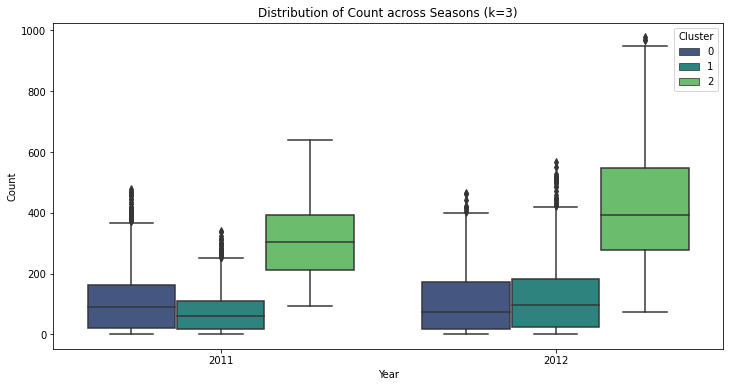

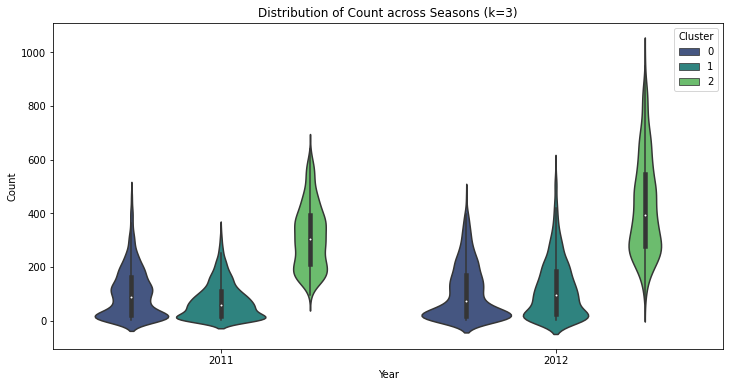

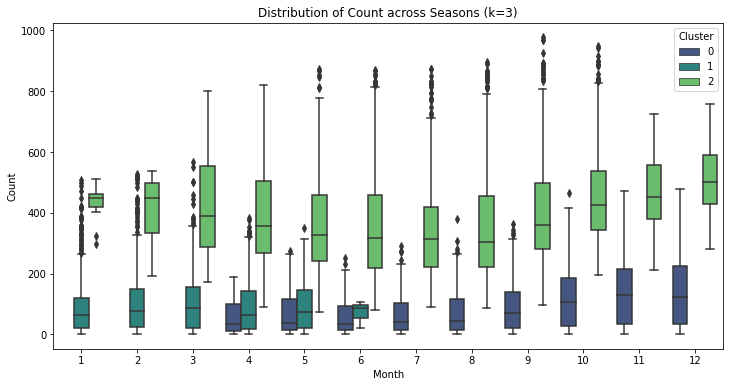

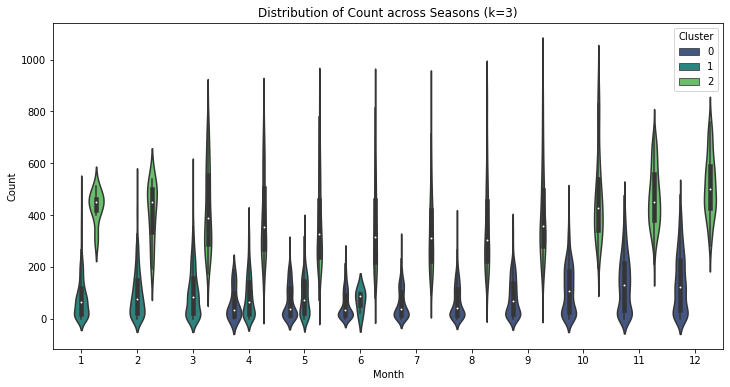

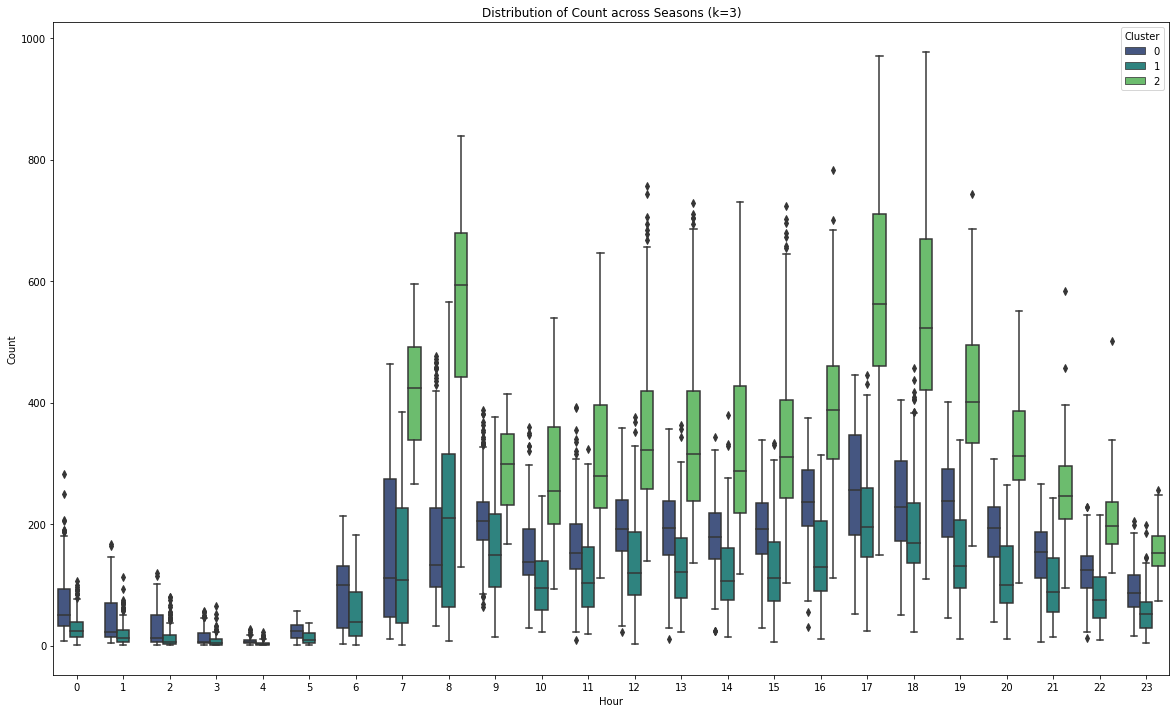

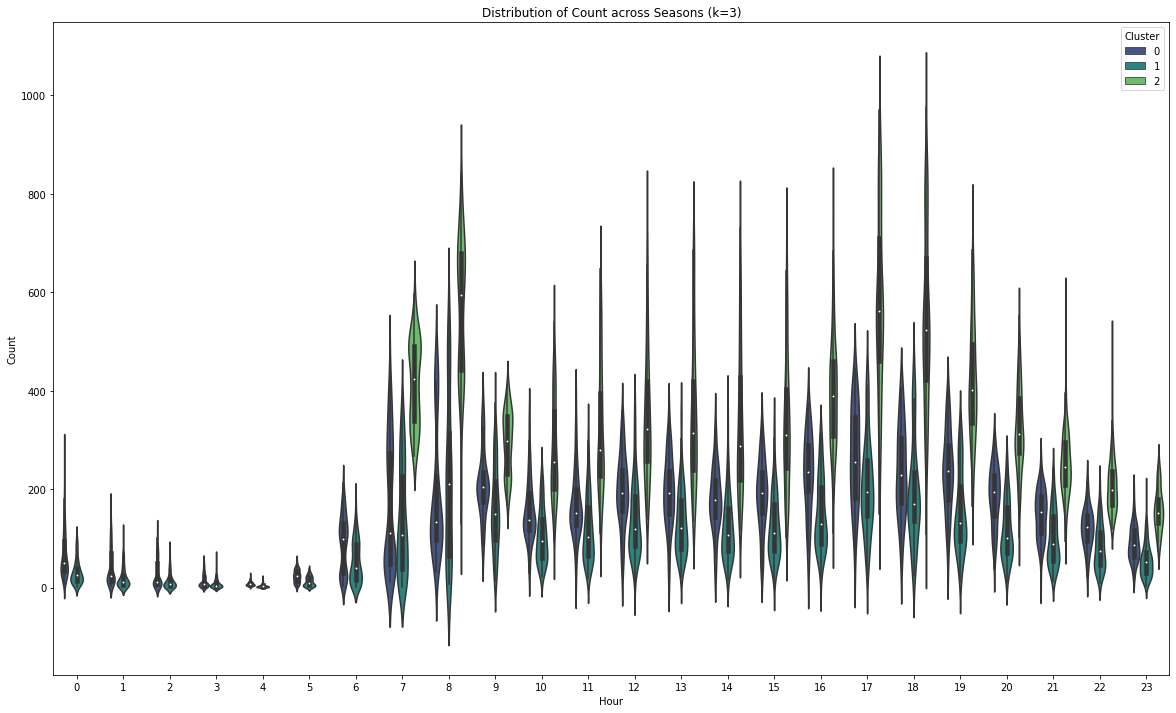

In [52]:
plot_distribution(pdf3, 3)

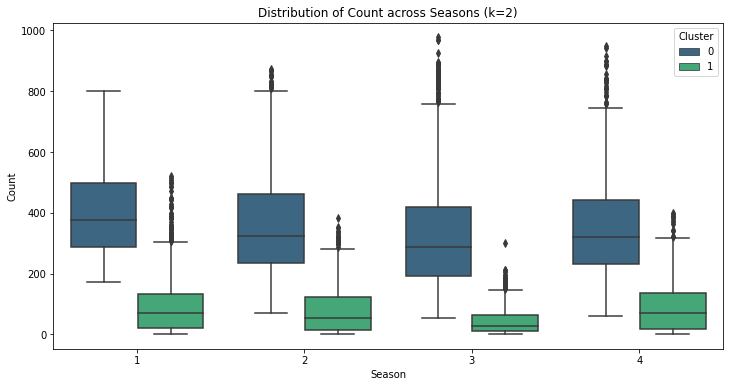

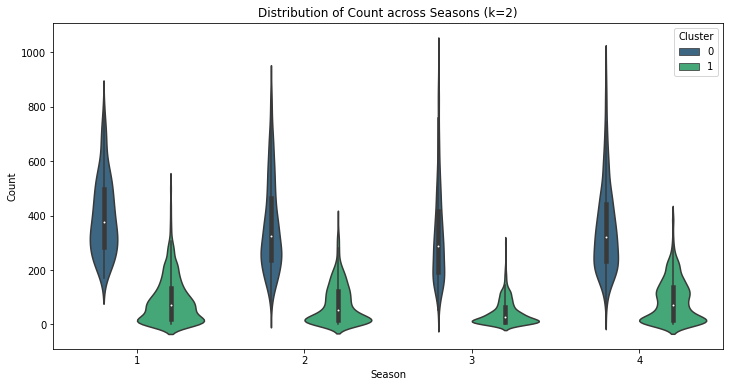

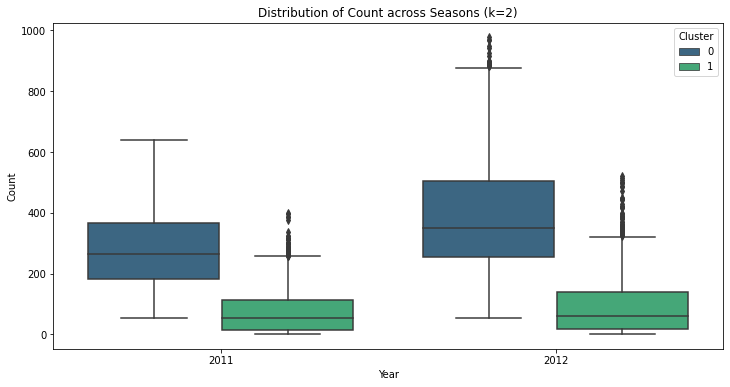

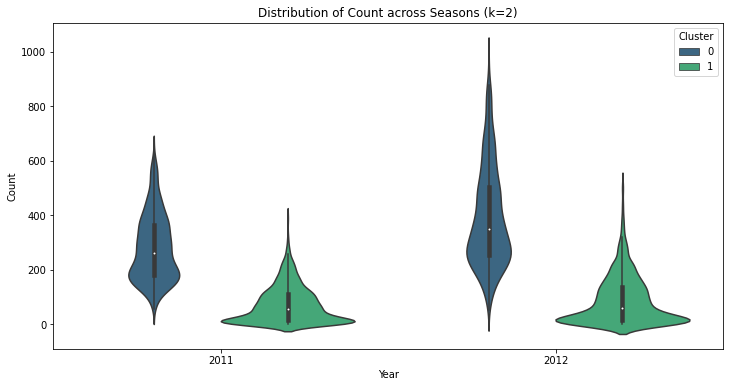

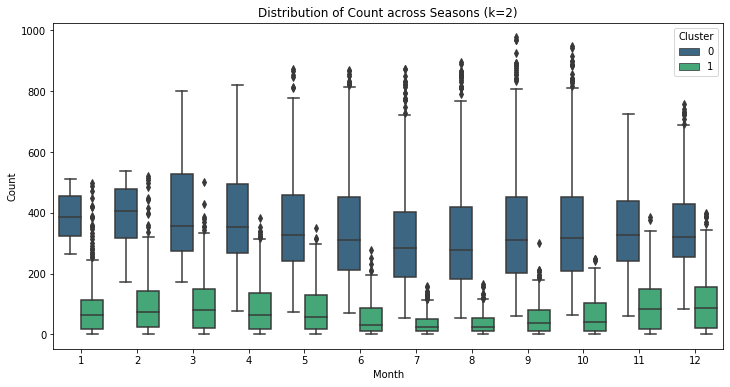

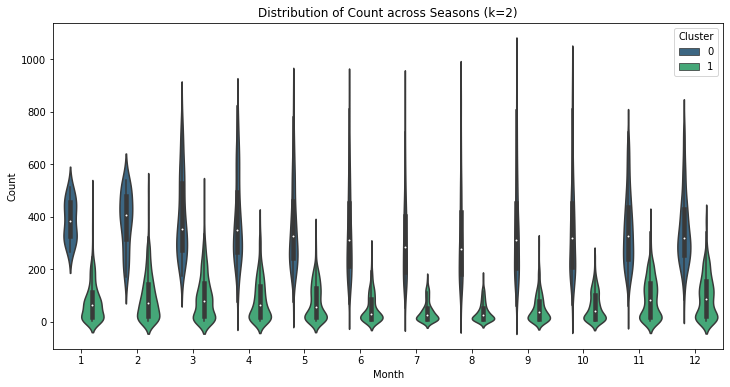

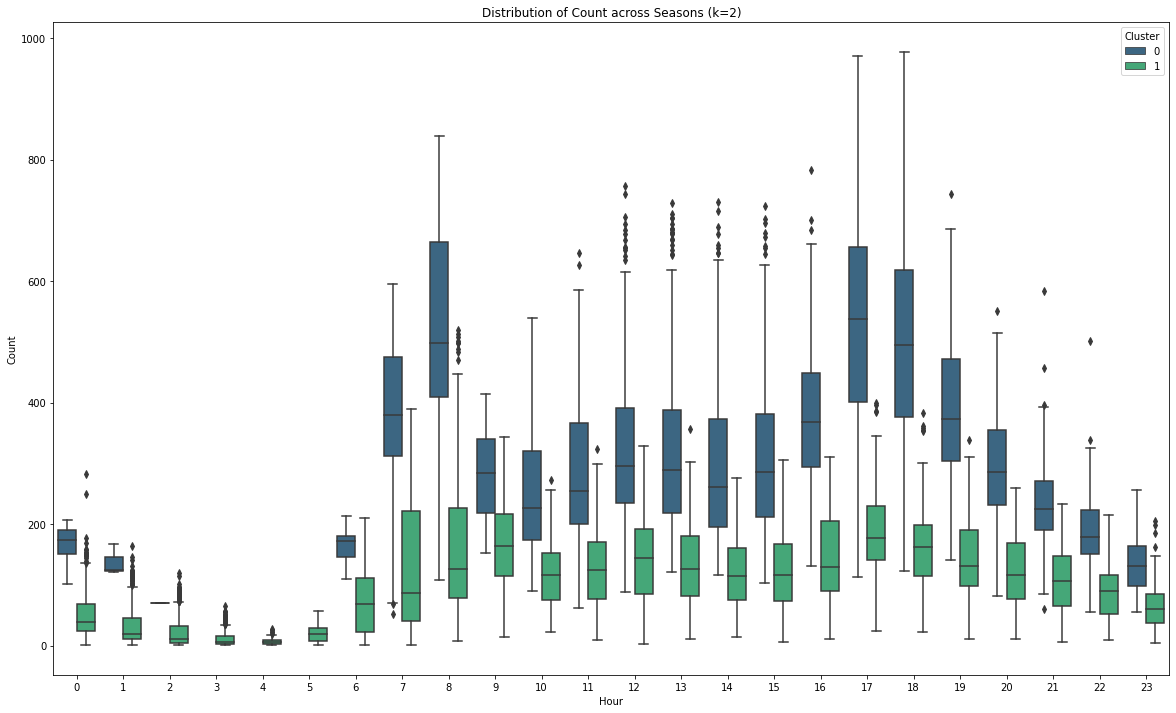

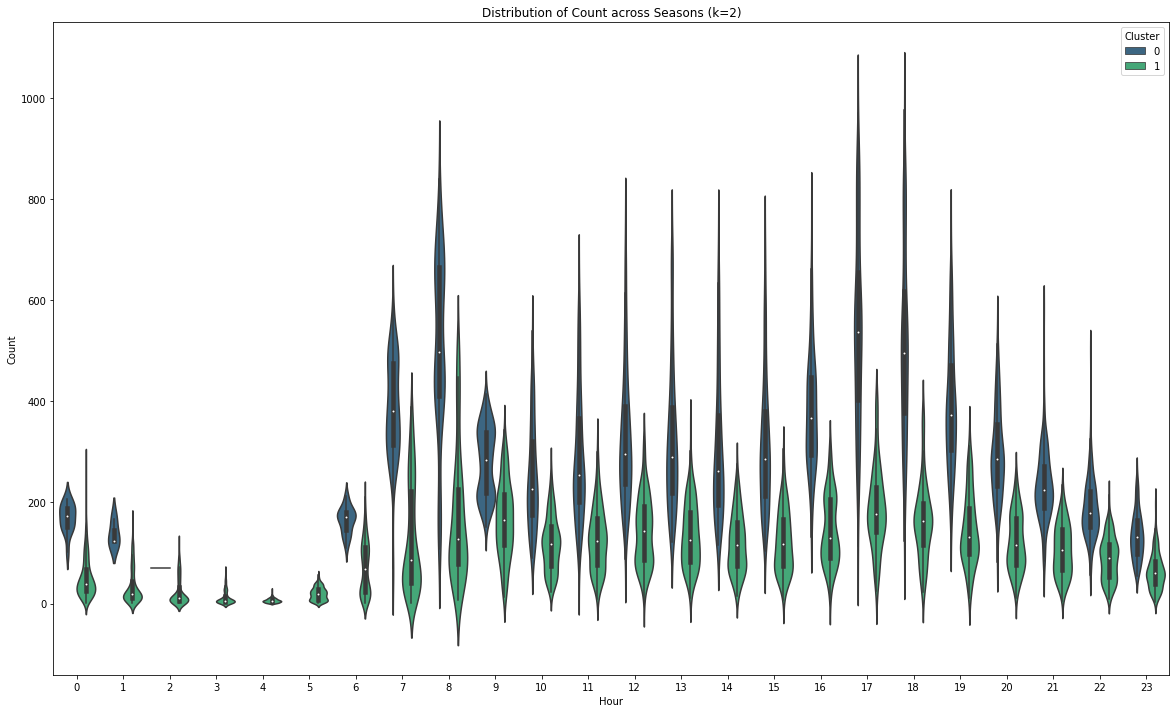

In [53]:
plot_distribution(pdf2, 2)

In [54]:
def plot_scatter_clusters_all(data, k, cols):
    # Plot scatter plots for specified columns
    for col in cols:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=col, y='count', hue='prediction', data=data, palette='viridis')
        plt.title(f'Scatter Plot of {col.capitalize()} vs Count (k={k})')
        plt.xlabel(col.capitalize())
        plt.ylabel('Count')
        plt.legend(title='Cluster')
        plt.show()

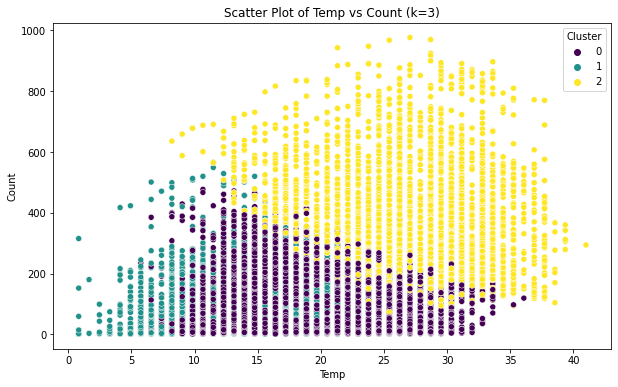

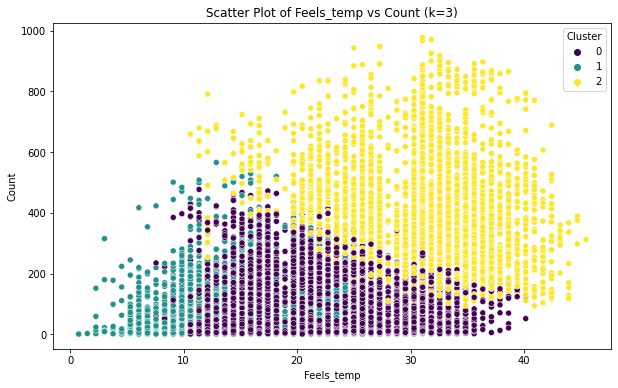

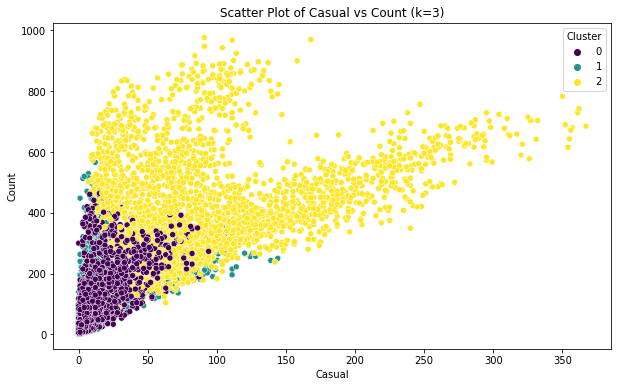

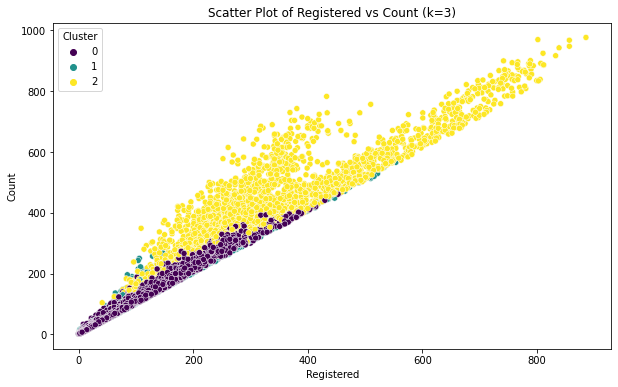

In [55]:
# Plot scatter plots for k=3
plot_scatter_clusters_all(pdf3, 3, ['temp', 'feels_temp', 'casual', 'registered'])

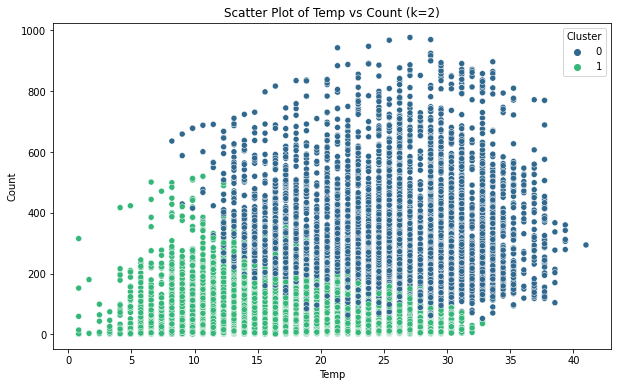

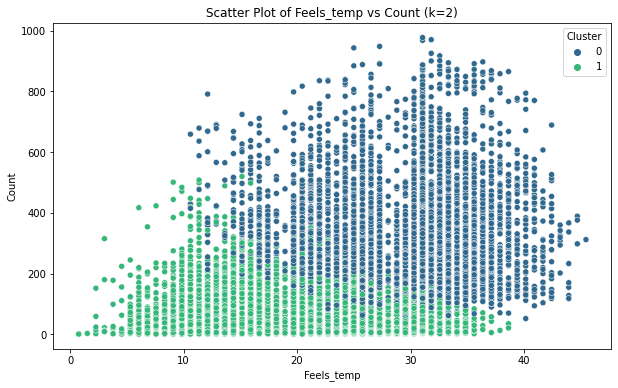

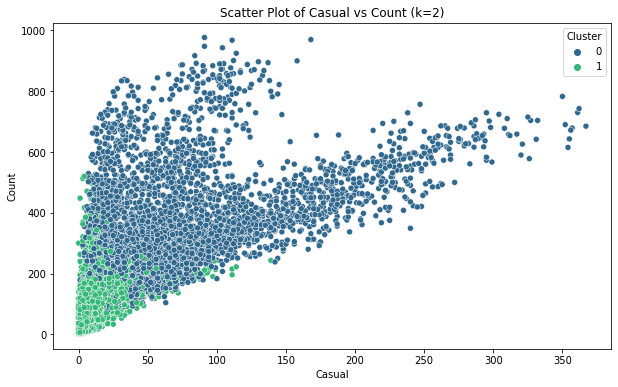

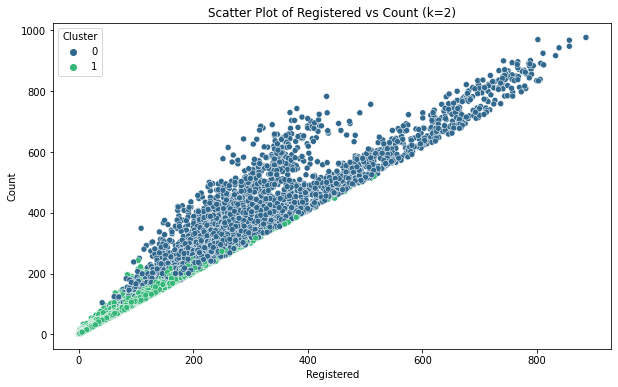

In [56]:
# Plot scatter plots for k=2
plot_scatter_clusters_all(pdf2, 2, ['temp', 'feels_temp', 'casual', 'registered'])

#### Linear Regression

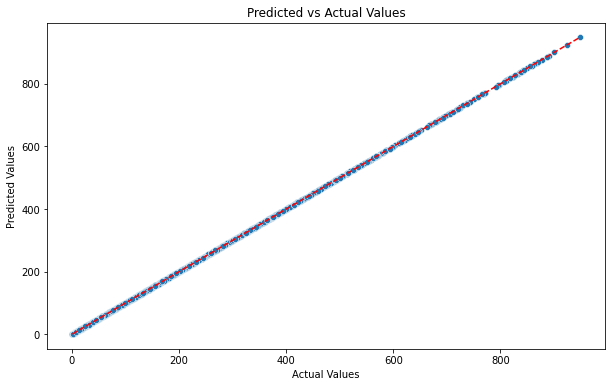

In [57]:
#Inspect Model Results

import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the test set
predictions = bestModel.transform(test)

# Collect predicted and actual values to the local environment for plotting
predictions_pd = predictions.select("prediction", "count").toPandas()

# Plot predicted vs. actual
plt.figure(figsize=(10, 6))
sns.scatterplot(x=predictions_pd['count'], y=predictions_pd['prediction'])
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.plot([predictions_pd['count'].min(), predictions_pd['count'].max()],
         [predictions_pd['count'].min(), predictions_pd['count'].max()],
         color='red', linestyle='--')  # Line y=x for reference
plt.show()


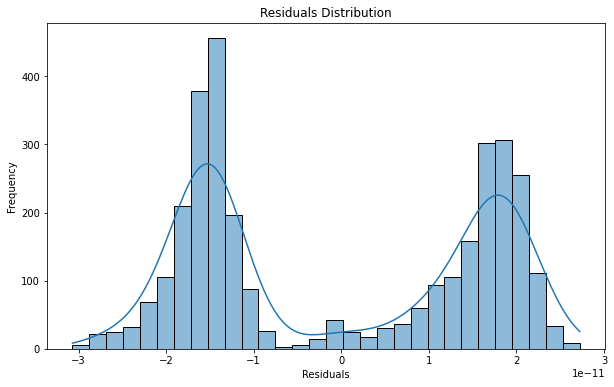

In [58]:
# Residuals Plot
residuals = predictions_pd['count'] - predictions_pd['prediction']
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()

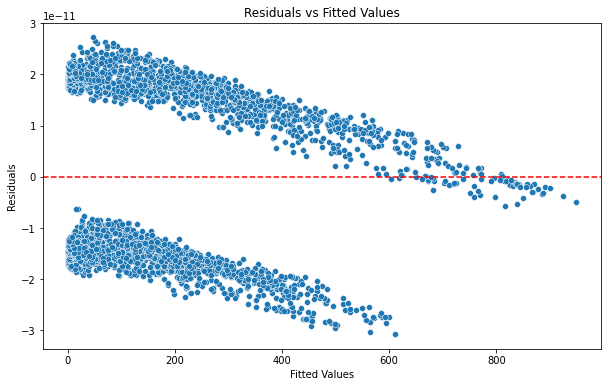

In [59]:
# Residuals vs. Fitted Values Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=predictions_pd['prediction'], y=residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.axhline(0, color='red', linestyle='--')
plt.show()

<Figure size 720x432 with 0 Axes>

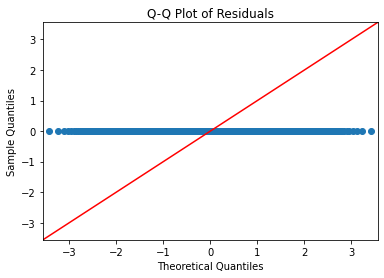

In [60]:
# Q-Q Plot of Residuals
import numpy as np
import statsmodels.api as sm

plt.figure(figsize=(10, 6))
sm.qqplot(np.array(residuals), line='45')
plt.title('Q-Q Plot of Residuals')
plt.show()

Iteration